## Load metadata

In [1]:
%load_ext autoreload
%autoreload 2
%pylab nbagg
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_table('data/base/behavior/trackingdata_goodscans.txt')

We will create a matrix X which contains a row of PANAS scores for each scan. Then, we will perform PCA via singular value decomposition and use the right singular vectors in V to determine which PANAS scores contribute to which of the principal components. The goal is to see if any of the components capture many fatigue/alertness related scores, so that we can use those to calculate an alertness index.

See Principal Component Analysis in Methods of [1]


[1] Betzel, R. F., Satterthwaite, T. D., Gold, J. I., & Bassett, D. S. (2017). Positive affect, surprise, and fatigue are correlates of network flexibility. Scientific Reports, 7(1), 1–10. https://doi.org/10.1038/s41598-017-00425-z

## Get PANAS vectors for each scan

The PANAS categories...

In [3]:
panas_cols = [_ for _ in df.columns if _.startswith('panas:')]
panas_cols

['panas:active',
 'panas:afraid',
 'panas:alert',
 'panas:alone',
 'panas:amazed',
 'panas:angry',
 'panas:angry_at_self',
 'panas:ashamed',
 'panas:astonished',
 'panas:at_ease',
 'panas:attentive',
 'panas:bashful',
 'panas:blameworthy',
 'panas:blue',
 'panas:bold',
 'panas:calm',
 'panas:cheerful',
 'panas:concentrating',
 'panas:confident',
 'panas:daring',
 'panas:delighted',
 'panas:determined',
 'panas:disgusted',
 'panas:disgusted_with_self',
 'panas:dissatisfied_with_self',
 'panas:distressed',
 'panas:downhearted',
 'panas:drowsy',
 'panas:energetic',
 'panas:enthusiastic',
 'panas:excited',
 'panas:fatigue',
 'panas:fearless',
 'panas:frightened',
 'panas:guilty',
 'panas:happy',
 'panas:hostile',
 'panas:inspired',
 'panas:interested',
 'panas:irritable',
 'panas:jittery',
 'panas:joyful',
 'panas:lively',
 'panas:loathing',
 'panas:lonely',
 'panas:negative',
 'panas:nervous',
 'panas:positive',
 'panas:proud',
 'panas:relaxed',
 'panas:sad',
 'panas:scared',
 'panas:scor

Create the matrix X

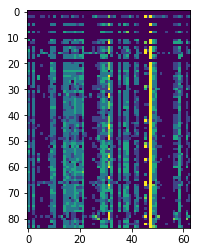

In [4]:
df_panas = df[panas_cols].replace('.', 0).astype(int)
X = df_panas.values

plt.close('all')
plt.imshow(X,vmin=0,vmax=5)
plt.show()

Remove scan sessions with all zero PANAS scores, or PANAS categories with all zeros.

(74, 60)


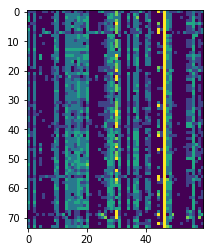

In [5]:
#X1 = np.array([scan for scan in X if np.any(scan)])
#X2 = np.array([cat for cat in X1.T if np.any(cat)]).T
sessions = df_panas.any(axis=1)
categories = df_panas.any(axis=0)

df_panas_clean = df_panas.loc[sessions, categories]
X2 = df_panas_clean.values

print(X2.shape)
plt.close('all')
plt.imshow(X2,vmin=0,vmax=5)
plt.show()

Z-score each PANAS category

(74, 60)


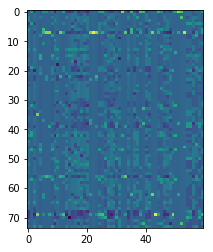

In [6]:
from scipy.stats import zscore
X3 = zscore(X2,axis=0)

print(X3.shape)
plt.close('all')
plt.imshow(X3)
plt.show()

## Singular Value Decomposition

In [7]:
U,S,Vh = np.linalg.svd(X3,full_matrices=False)
V = Vh.T
print(U.shape)
print(S.shape)
print(Vh.shape)

(74, 60)
(60,)
(60, 60)


(60, 60)


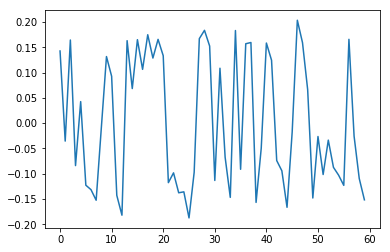

In [8]:
print(V.shape)
plt.close('all')
plt.plot(V[:,0])
plt.show()

## Components from PCA

In [9]:
from sklearn.decomposition import PCA
pca = PCA()
U = pca.fit_transform(X3)
V = pca.components_

print("X has shape:", X3.shape)
print("U has shape:", U.shape)
print("V has shape:", V.shape)

X has shape: (74, 60)
U has shape: (74, 60)
V has shape: (60, 60)


Create new DataFrame of pca components.

In [10]:
df_pca = pd.DataFrame(
    pca.components_, 
    columns=df_panas_clean.columns
    )

# relabel index
df_pca.index = df_pca.index.map('PC_{}'.format)

print(df_pca.shape)

(60, 60)


Plot component weights for each column.

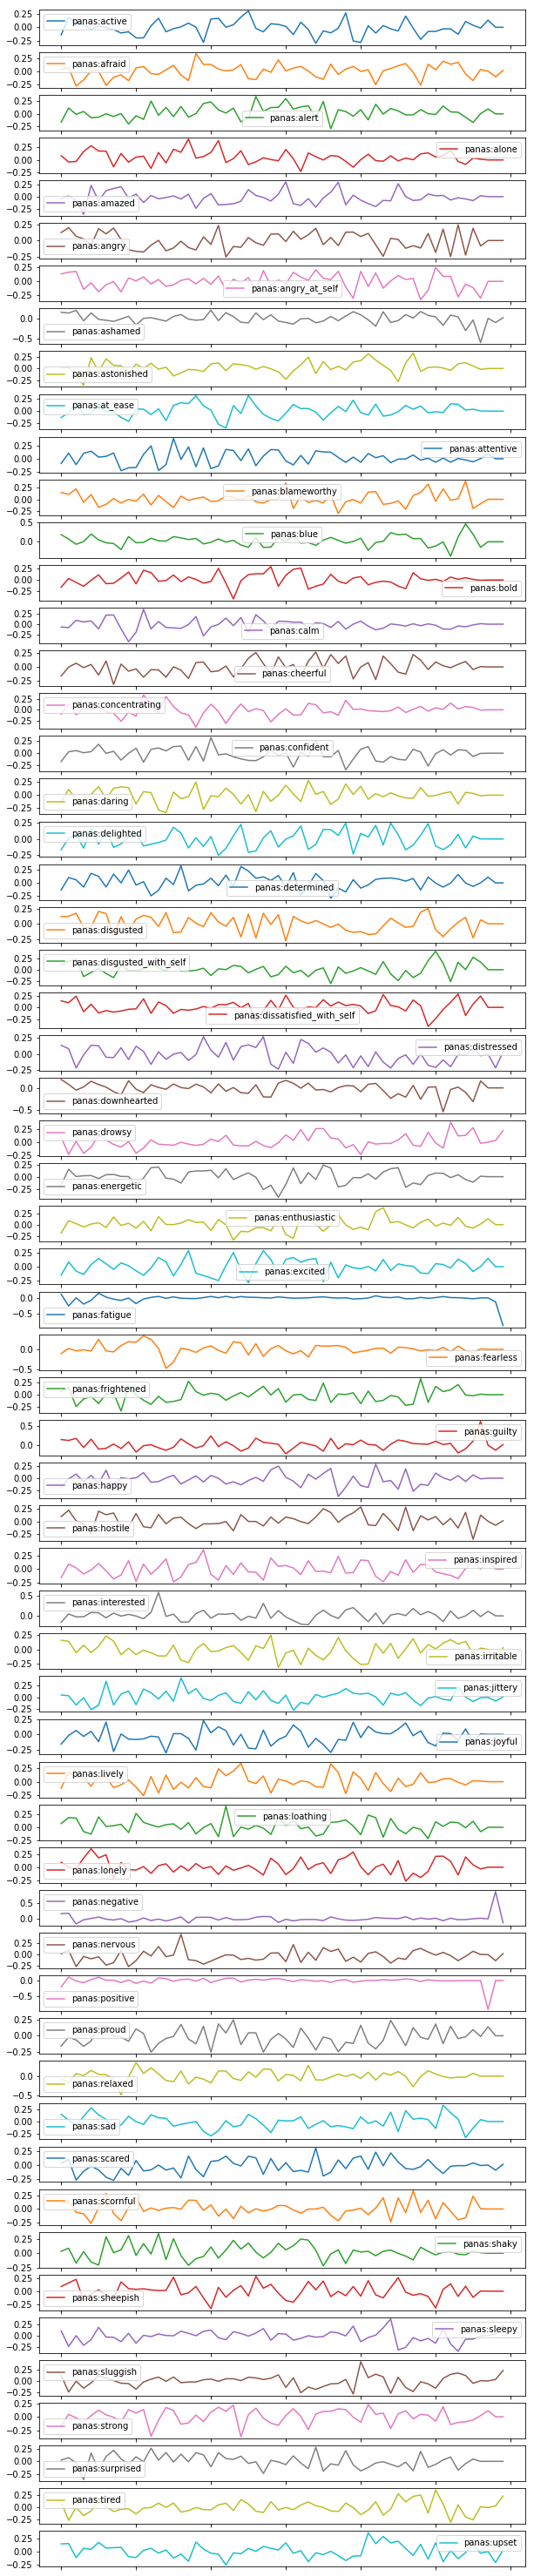

In [11]:
_ = df_pca.plot(subplots=True, figsize=(10, df_pca.shape[1]))

Plot component weights for fatigue column.

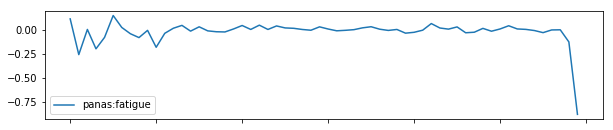

In [12]:
_ = df_pca.plot(y='panas:fatigue', figsize=(10, 2))

Find component that assigns highest weight to fatigue.

In [13]:
PC_fatigue = df_pca['panas:fatigue'].idxmax()
PC_fatigue

'PC_5'

Plot component that assigns highest weight to fatigue.

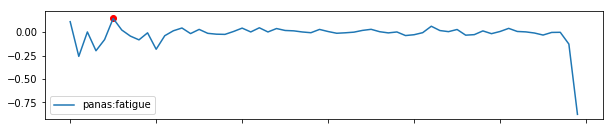

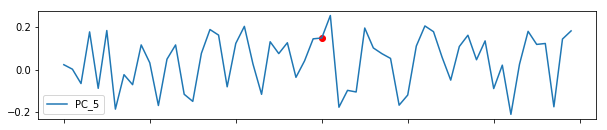

In [14]:
# plot panas:fatigure over components 
ax = df_pca.plot(y='panas:fatigue', figsize=(10, 2))
ax.scatter(
    df_pca.index.get_loc(PC_fatigue), 
    df_pca.loc[PC_fatigue, 'panas:fatigue'], 
    marker='o', color='r'
    )

# plot component over columns
ax = df_pca.T.plot(y=PC_fatigue, figsize=(10, 2))
ax.scatter(
    df_pca.T.index.get_loc('panas:fatigue'), 
    df_pca.T.loc['panas:fatigue', PC_fatigue], 
    marker='o', color='r'
    )

## Wrap all of this into a function

In [15]:
def clean_meta(df, columns=None, zscore=False, **kwargs):
    """ Clean meta DataFrame, zscore.
    """
    # copy input df
    df_clean = df.copy()
    
    # select columns
    if columns is not None:
        df_clean = df_clean[columns]
    
    # replace non-numerics
    df_clean = df_clean.replace('.', 0.0)
    df_numeric = df_clean.astype(str).applymap(str.isnumeric)
    df_clean[df_numeric==False] = np.nan
    df_clean = df_clean.fillna(0.0)

    # only keep numeric data, convert to float
    df_clean = df_clean.astype(float)
    
    # z-score values
    if zscore is True:
        from scipy.stats import zscore
        good_rows = df_clean.any(axis=1)
        good_cols = df_clean.any(axis=0)
        df_nonzero = df_clean.loc[good_rows, good_cols]
        df_clean.loc[good_rows, good_cols] = zscore(df_nonzero, axis=0)
    
    # fill nans
    df_clean = df_clean.fillna(0.0)
    
    # return cleaned
    return df_clean


Given meta DataFrame and a column, return PC with max weight for column

In [16]:
def get_pc(df, columns=None):
    """ Find PC with max weight assigned to column.
    """
    # extract X
    X = df.values
    
    # fit transform PCA
    from sklearn.decomposition import PCA
    pca = PCA()
    U = pca.fit_transform(X)
    V = pca.components_
    
    # create new DataFrame of components (V)
    df_V = pd.DataFrame(V, columns=df.columns)
    df_V.index = df_V.index.map('PC_{}'.format)
   
    # create new DataFrame of embedding (U)
    df_U = pd.DataFrame(U, index=df.index, columns=df_V.index)
    
    # set column to 0,1 or idxmax   
    if columns is None:
        columns = pd.Series(df_U.columns[:2])
    else:
        columns = [_ for _ in np.ravel(columns)]
        columns = df_V[columns].idxmax()   

    # return PC for col
    df_PC = df_U[columns]
    df_PC.columns = dict(columns).items()
    return df_PC


Test it all out.

In [17]:
# load meta into DataFrame
df = pd.read_table('data/base/behavior/trackingdata_goodscans.txt')

# panas cols
panas_cols = [_ for _ in df.columns if _.startswith('panas:')]

# clean meta
df_panas = clean_meta(df, columns=panas_cols)#, zscore=True)

# get first PC
df_pc = get_pc(df_panas)

# get PC (max) for panas:fatigue, panas:energetic
df_pc_meta = get_pc(df_panas, columns=['panas:fatigue', 'panas:energetic'])

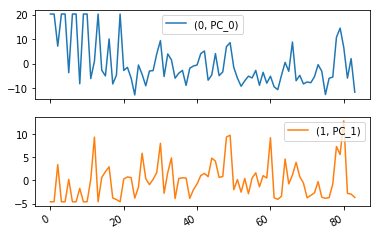

In [18]:
_ = df_pc.plot(subplots=True)

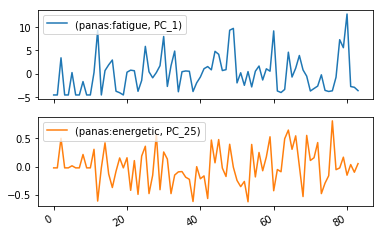

In [19]:
_ = df_pc_meta.plot(subplots=True)

## Color graphs by PCs

In [20]:
from load_data import load_scrubbed

combined = load_scrubbed(n_sessions=-1, merge=True)

INFO:load_data:load_scrubbed(**{'n_sessions': -1, 'merge': True})
INFO:load_data:Loading data...
INFO:root:  [+] session: 1, path: data/base/combined_data_scrubbed/sub014.txt
INFO:root:  [+] session: 2, path: data/base/combined_data_scrubbed/sub015.txt
INFO:root:  [+] session: 3, path: data/base/combined_data_scrubbed/sub016.txt
INFO:root:  [+] session: 4, path: data/base/combined_data_scrubbed/sub017.txt
INFO:root:  [+] session: 5, path: data/base/combined_data_scrubbed/sub018.txt
INFO:root:  [+] session: 6, path: data/base/combined_data_scrubbed/sub019.txt
INFO:root:  [+] session: 7, path: data/base/combined_data_scrubbed/sub020.txt
INFO:root:  [+] session: 8, path: data/base/combined_data_scrubbed/sub021.txt
INFO:root:  [+] session: 9, path: data/base/combined_data_scrubbed/sub022.txt
INFO:root:  [+] session: 10, path: data/base/combined_data_scrubbed/sub023.txt
INFO:root:  [+] session: 11, path: data/base/combined_data_scrubbed/sub024.txt
INFO:root:  [+] session: 12, path: data/bas

In [29]:
sessions = load_scrubbed(n_sessions=20, merge=False)

INFO:load_data:load_scrubbed(**{'n_sessions': 20, 'merge': False})
INFO:load_data:Loading data...
INFO:root:  [+] session: 1, path: data/base/combined_data_scrubbed/sub014.txt
INFO:root:  [+] session: 2, path: data/base/combined_data_scrubbed/sub015.txt
INFO:root:  [+] session: 3, path: data/base/combined_data_scrubbed/sub016.txt
INFO:root:  [+] session: 4, path: data/base/combined_data_scrubbed/sub017.txt
INFO:root:  [+] session: 5, path: data/base/combined_data_scrubbed/sub018.txt
INFO:root:  [+] session: 6, path: data/base/combined_data_scrubbed/sub019.txt
INFO:root:  [+] session: 7, path: data/base/combined_data_scrubbed/sub020.txt
INFO:root:  [+] session: 8, path: data/base/combined_data_scrubbed/sub021.txt
INFO:root:  [+] session: 9, path: data/base/combined_data_scrubbed/sub022.txt
INFO:root:  [+] session: 10, path: data/base/combined_data_scrubbed/sub023.txt
INFO:root:  [+] session: 11, path: data/base/combined_data_scrubbed/sub024.txt
INFO:root:  [+] session: 12, path: data/ba

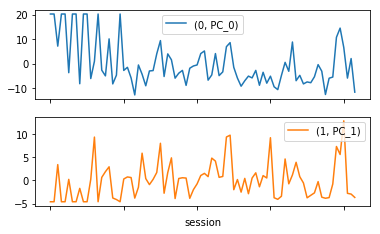

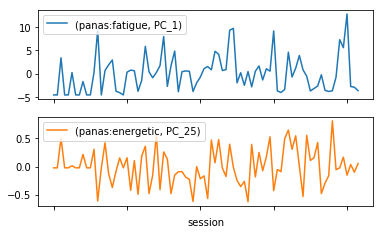

In [25]:
# panas cols
panas_cols = [_ for _ in combined.meta.columns if _.startswith('panas:')]

# clean meta
df_panas = combined.meta[panas_cols]

# group by session
df_panas = df_panas.groupby('session').mean()

# get first PC
df_pc = get_pc(df_panas)
_ = df_pc.plot(subplots=True)

# get PC (max) for panas:fatigue, panas:energetic
df_pc_meta = get_pc(df_panas, columns=['panas:fatigue', 'panas:energetic'])
_ = df_pc_meta.plot(subplots=True)


In [30]:
for i, session in enumerate(sessions):
    print(i, session.meta.session_id.unique())
    
    # get components from df_pc, df_pc_meta
    session_index = session.meta.set_index('session').index
    y_pc = df_pc.loc[session.meta.session, :].reset_index(drop=True)
    y_pc_meta = df_pc_meta.loc[session.meta.session, :].reset_index(drop=True)

    # set color functions
    sessions[i].color_functions = y_pc.join(y_pc_meta, how='left')


0 [14]
1 [15]
2 [16]
3 [17]
4 [18]
5 [19]
6 [20]
7 [21]
8 [22]
9 [23]
10 [24]
11 [25]
12 [26]
13 [27]
14 [28]
15 [29]
16 [30]
17 [32]
18 [35]
19 [36]


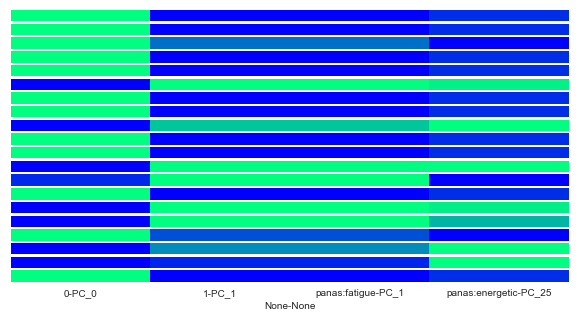

In [31]:
import seaborn as sns
sns.set_style('darkgrid')

fig, axes = plt.subplots(len(sessions), 1, figsize=(10, 5))
for i, session in enumerate(sessions):
    
    # plot color functions 
    sns.heatmap(session.color_functions, ax=axes[i], cbar=False, cmap='winter')
    axes[i].set_yticks([])
    if i < len(sessions)-1:
        axes[i].axis('off')